# House Price Prediction


## Project Guide

- [Project Overview](#overview)
- [Data Cleaning & Exploration](#exploration)
- [Modeling with Linear Algebra](#linearAlgebra)
- [Modeling with Scikit Learn](#sklearn)
- [Conclusion](#conclusion)

<a id = "overview"></a>
## Project Overview

This project uses [Kaggle's House Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) to discuss regression models for predicting continuous outputs. Before using `scikit-learn` package for modeling, the workbook will also include data exploration/cleaing and try to apply linear algebra algorithm with `numpy` package to reproduce modeling functions under the hood.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.2, 10.0)

In [2]:
### Read in the data
df = pd.read_csv('../project-house-price-prediction/data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Observe missing values
Alley, FireplaceQu, PoolQC, Fence, and MiscFeature have high portion of missing values.

In [3]:
# There are some columns with high percentage of missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

#### Observe the distribution of numeric columns
Some actions from observation:
1. Id should be removed from the dataset
2. TotalBsmtSF should be removed to avoid multicollinearity with BsmtFinSF1, bsmtFinSF2, and BsmtUnfSF
3. Transform YearBuilt, YearRemodAdd, and GarageYrBlt to new variables Age of Building/Remodel/Garage.
4. At first glance, MoSold and YrSold don't seem to be very relevant to price. The relationship between these two variable with SalePrice will be examined later.
5. Fill in the missing value in LotFrontage and MasVnrArea with mean value

In [4]:
df_numeric = df.select_dtypes(include = ['int64', 'float64'])
df_numeric.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


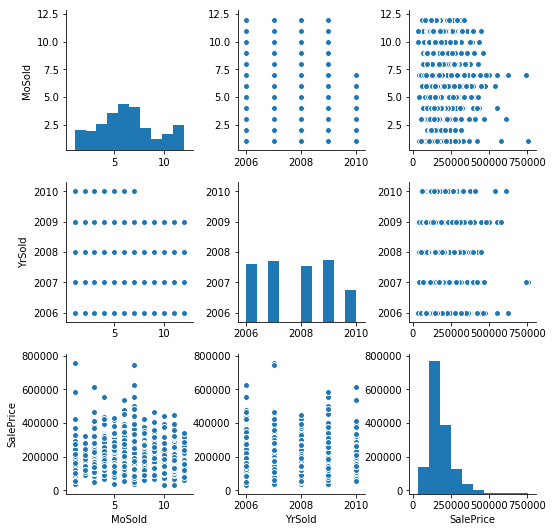

In [5]:
# MoSold and YrSold doesn't seem to be very indicative of SalesPrice
sns.pairplot(df[['MoSold', 'YrSold', 'SalePrice']])
plt.show()

#### Observe the correlation of numeric variables
1. GarageYrBlt and YearBuilt are highly correlated. GarageYrBlt could be removed.
2. TotRomsAbvGrd and GrLivArea are highly correlated. TotRomsAbvGrd could be removed.

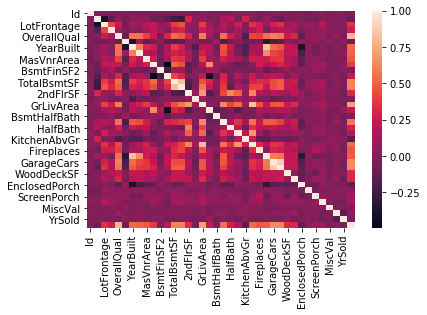

In [6]:
ax = sns.heatmap(df_numeric.corr())

#### Observe the value of non-numeric variables

In [46]:
df_nonNumeric = df.select_dtypes(include = ['object'])
df_nonNumeric_desc = df_nonNumeric.describe().T
df_nonNumeric_desc

#### Observe the relationship between non-numeric variables and SalePrice

In [8]:
# Tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [9]:
# for some reason tukeyhsd() doesn't work for CentralAir
df_nonNumeric2 = df_nonNumeric.drop(['CentralAir'], axis=1)
tukey_result = []
for col in df_nonNumeric2.columns:
    mc = MultiComparison(df['SalePrice'], df_nonNumeric[col].factorize()[0]) # use factorize to handel null values
    result = mc.tukeyhsd()
    tukey_result.append(sum(result.reject)) # get the number of pairs with significant difference

In [10]:
df_nonNumeric_desc = df_nonNumeric_desc.drop(['CentralAir'])
df_nonNumeric_desc['TukeyTest'] = tukey_result
df_nonNumeric_desc

,count,unique,top,freq,TukeyTest
MSZoning,1460,5,RL,1151,6
Street,1460,2,Pave,1454,0
Alley,91,2,Grvl,50,2
LotShape,1460,4,Reg,925,3
LandContour,1460,4,Lvl,1311,4
Utilities,1460,2,AllPub,1459,0
LotConfig,1460,5,Inside,1052,3
LandSlope,1460,3,Gtl,1382,0
Neighborhood,1460,25,NAmes,225,174
Condition1,1460,9,Norm,1260,4


In [12]:
# pair-wise test for CentralAir
from scipy import stats

In [13]:
f, p = stats.f_oneway(df.SalePrice[df.CentralAir == 'Y'],
                      df.SalePrice[df.CentralAir == 'N'])
print('p value:', p)

p value: 1.80950615593e-22


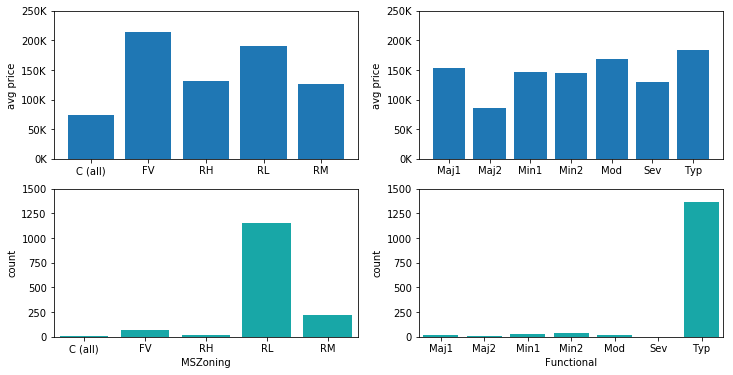

In [11]:
# Observe columns with and without significant pairs in TukeyTest
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
df1 = df[['MSZoning', 'SalePrice']].groupby('MSZoning').mean()
plt.bar(list(df1.index), df1['SalePrice'])
plt.ylabel('avg price')
plt.yticks((0, 50000, 100000, 150000, 200000, 250000), ('0K', '50K', '100K', '150K', '200K', '250K'))

plt.subplot(2,2,2)
df2 = df[['Functional', 'SalePrice']].groupby('Functional').mean()
plt.bar(list(df2.index), df2['SalePrice'])
plt.ylabel('avg price')
plt.yticks((0, 50000, 100000, 150000, 200000, 250000), ('0K', '50K', '100K', '150K', '200K', '250K'))

plt.subplot(2,2,3)
sns.countplot(df['MSZoning'], order=sorted(list(df['MSZoning'].unique())), color='c')
plt.ylim((0, 1500))

plt.subplot(2,2,4)
sns.countplot(df['Functional'], order=sorted(list(df['Functional'].unique())), color='c')
plt.ylim((0, 1500))

#plt.tight_layout()
plt.show()

The distribution is very unbalanced across non-numeric variables, even for those with significent differences. These variables won't be much helpful for modeling after being transferred to dummy columns. Therefore, only keep variables with enough sample sizes across categories and more than 1 pair of significance.

In [73]:
nonNumeric_cols_select = (
    df_nonNumeric_desc['count'] == 1460) & (
    df_nonNumeric_desc['freq'] <= 800) & (
    df_nonNumeric_desc['TukeyTest'] >= 2)
df_nonNumeric_desc[nonNumeric_cols_select]

,count,unique,top,freq,TukeyTest
Neighborhood,1460,25,NAmes,225,174
HouseStyle,1460,8,1Story,726,9
Exterior1st,1460,15,VinylSd,515,17
Exterior2nd,1460,16,VinylSd,504,24
Foundation,1460,6,PConc,647,4
HeatingQC,1460,5,Ex,741,4
KitchenQual,1460,4,TA,735,6


#### Get the cleaned data set

In [77]:
# write function for it
def data_cleaning(data_frame, cols_to_drop, target_col):
    """
    The function will take parameters of the data frame, columns to drop, and the target columns
    to incorporate all the data cleaning actions identified through data exploration
    and get the cleaned datasets, X and y, for modeling.
    """
    # Age of building/remodle from YearBuilt and YearRemodAdd
    data_frame['AgeBuilding'] = 2012 - data_frame['YearBuilt']
    data_frame['AgeRemodel'] = 2012 - data_frame['YearRemodAdd']
    
    # Drop numeric columns
    df_dropped = data_frame.drop(drop_col.append(target_col), axis=1)
    
    # Fill NA for numeric columns
    df_numeric = df_dropped.select_dtype(include=['int64', 'float64']).apply(lambda x: x.fillna(x.mean()), axis=1)
    
    df_nonNumeric = df_dropped.select_dtype(include=['object'])
    X = pd.concat([df_numeric, pd.get_dummies(df_nonNumeric)], axis=1)
    y = data_frame[target_col]
    
    return X, y

In [ ]:
#cols_to_drop = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 
#                'TotalBsmtSF', 'TotRmsAbvGrd', 'MoSold', 'YrSold']
df_nonNumeric_desc[!nonNumeric_cols_select]

In [49]:
# Age of building/remodle from YearBuilt and YearRemodAdd
df_numeric['AgeBuilding'] = 2012 - df_numeric['YearBuilt']
df_numeric['AgeRemodel'] = 2012 - df_numeric['YearRemodAdd']
# Fill NA
df_numeric = df_numeric.apply(lambda x: x.fillna(x.mean()), axis = 1)
# Columns to drop
drop_col = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 
            'TotalBsmtSF', 'TotRmsAbvGrd', 
            'MoSold', 'YrSold', 'SalePrice']
df_numeric_clean = df_numeric.drop(drop_col, axis = 1)

In [34]:
df_nonNumeric_clean = df_nonNumeric.copy()[sig_nonNumeric_cols]
for col in df_nonNumeric_categorical.columns:
    df_nonNumeric_clean[col] = df_nonNumeric_clean[col].fillna('NA')
df_nonNumeric_clean.info()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_NA,Alley_Pave,LotShape_IR1,LotShape_IR2,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,CentralAir_N,CentralAir_Y
0,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
1,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,1
3,0,0,0,1,0,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,1


<a id = "sklearn"></a>
## Modeling

#### X and y

In [43]:
#X = pd.concat([df_numeric_clean, # Numreic columns   
#               pd.get_dummies(df_nonNumeric) # non-Numeric columns
#              ], axis = 1).as_matrix()

X = df_numeric_clean.as_matrix()
X.shape

(1460, 31)

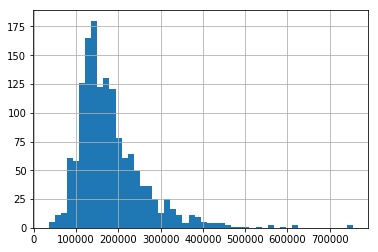

In [18]:
y = df.SalePrice
y.hist(bins=50)
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [45]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R-squared:", lr.score(X_test, y_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R-squared: 0.816274002607
RMSE: 35805.8268461


<a id = "conclusion"></a>
## Performance & Conclusion